# 詐騙犯罪統計資料
* 資料來源：[政府資料開放平台](https://data.gov.tw/dataset/98176)
* 用途：了解詐騙趨勢
* 時間：2025/4/25

## 1. 導入相關函式庫
* `Requests`：發送 HTTP 請求
* `Bs4`：從 HTML 和 XML 文件中提取數據
* `Matplotlib`：數據可視化庫

In [39]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import re

## 2. 爬取網頁
* 爬取所有API下載檔案
* 對所有API下載檔案進行合併

In [11]:
TARGET_URL = "https://data.gov.tw/dataset/98176"
HEADERS = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36'
}

In [12]:
def get_api_links(url):
    # 爬取所有 API 下載連結
    response = requests.get(url, headers=HEADERS)
    response.encoding = 'utf-8'
    soup = BeautifulSoup(response.text, 'html.parser')
    links = [a_tag.get('href') for a_tag in soup.find_all('a', title='API下載檔案') if a_tag.get('href')]
    print(f"{len(links)} 筆 API 連結")
    return links

In [13]:
# 測試
api_links = get_api_links(TARGET_URL)

26 筆 API 連結


In [23]:
def process_api(url):
    # 處理單一 API JSON 並回傳 DataFrame，支援異常重試
    try:
        res = requests.get(url, headers=HEADERS)
        res.raise_for_status()
        json_data = res.json()
        records = json_data['result']['records']
        if len(records) < 2:
            print(f"資料筆數不足： {url}\n")
            return pd.DataFrame()
        df = pd.DataFrame(records[1:])
        print(f"成功下載： {url} (筆數： {len(df)})\n")
        return df
    except Exception as e:
        print(f"無法處理: {url} (錯誤： {e})\n")
        return pd.DataFrame()

In [22]:
def inspect_column_labels(api_urls, workers=8):
    # 合併所有 API JSON 並回傳 Merged DataFrame
    dfs = []
    column_sets = []
    with ThreadPoolExecutor(max_workers=workers) as executor:
        futures = {executor.submit(process_api, url): url for url in api_urls}
        for future in as_completed(futures):
            df = future.result()
            if not df.empty:
                dfs.append(df)
                column_sets.append(set(df.columns))
                # print(f"URL： {futures[future]}\n欄位： {list(df.columns)}")
    
    # 檢查是否所有欄位都相同
    # frozenset([iter]): Freeze the list, and make it unchangeable
    unique_column_sets = list(map(frozenset, column_sets))
    if len(set(unique_column_sets)) == 1:
        print(f"所有資料表的欄位完全相同，直接合併\n")
        merged_df = pd.concat(dfs, ignore_index=True)
        return merged_df
    else:
        # 只保留共同欄位
        common_cols = set.intersection(*column_sets)
        print(f"取交集欄位，共 {len(common_cols)} 欄\n欄位： {common_cols}\n")
        dfs = [df[list(common_cols)] for df in dfs]
        merged_df = pd.concat(dfs, ignore_index=True)
        return merged_df

In [24]:
# 測試
merged_df = inspect_column_labels(api_links)

成功下載： https://od.moi.gov.tw/api/v1/rest/datastore/A01010000C-001402-001 (筆數： 759)

成功下載： https://od.moi.gov.tw/api/v1/rest/datastore/A01010000C-001402-057 (筆數： 479)

成功下載： https://od.moi.gov.tw/api/v1/rest/datastore/A01010000C-001402-025 (筆數： 719)

成功下載： https://od.moi.gov.tw/api/v1/rest/datastore/A01010000C-001402-053 (筆數： 241)

成功下載： https://od.moi.gov.tw/api/v1/rest/datastore/A01010000C-001402-017 (筆數： 798)

成功下載： https://od.moi.gov.tw/api/v1/rest/datastore/A01010000C-001402-041 (筆數： 501)

成功下載： https://od.moi.gov.tw/api/v1/rest/datastore/A01010000C-001402-045 (筆數： 625)

成功下載： https://od.moi.gov.tw/api/v1/rest/datastore/A01010000C-001402-093 (筆數： 2999)

成功下載： https://od.moi.gov.tw/api/v1/rest/datastore/A01010000C-001402-005 (筆數： 511)

成功下載： https://od.moi.gov.tw/api/v1/rest/datastore/A01010000C-001402-065 (筆數： 518)

成功下載： https://od.moi.gov.tw/api/v1/rest/datastore/A01010000C-001402-089 (筆數： 477)

成功下載： https://od.moi.gov.tw/api/v1/rest/datastore/A01010000C-001402-101 (筆數： 2999)

成功

In [29]:
# 測試
pd.set_option('display.max_rows', None)
display(merged_df.head())

,type,oc_dt,oc_p1
0,電信詐欺,1071001,新北市泰山區
1,電信詐欺,1071001,新竹縣竹北市
2,電信詐欺,1071001,基隆市中正區
3,電信詐欺,1071001,新竹縣竹北市
4,電信詐欺,1071001,苗栗縣苗栗市


In [38]:
# 缺失值檢查
missing_counts = merged_df.isnull().sum()
missing_cols = missing_counts[missing_counts > 0]
if missing_cols.empty:
    print("沒有欄位有缺失值")
else:
    print(missing_cols)

沒有欄位有缺失值


In [150]:
# type 所有不同的值
unique_types = merged_df['type'].unique()
print(f"Type 欄位共有 {len(unique_types)} 種不同的值")
print(f"分別是： {unique_types}")
# 每種類型出現的次數
type_counts = merged_df['type'].value_counts()
print(f"Type 欄位的值及其出現次數： \n{type_counts}")

Type 欄位共有 1 種不同的值
分別是： ['電信詐欺']
Type 欄位的值及其出現次數： 
type
電信詐欺    22278
Name: count, dtype: int64


## 3. 資料預處理
* 找出空值
* 找出異常值

In [112]:
def check_date_format(date_str):
    # 判斷日期是否有異常值
    try:
        if len(date_str) == 7:  
            year = int(date_str[:3]) + 1911
            month = int(date_str[3:5])
            day = int(date_str[5:7])
        elif len(date_str) == 8:  
            year = int(date_str[:4])
            month = int(date_str[4:6])
            day = int(date_str[6:8])
        else:
            return False

        pd.Timestamp(year=year, month=month, day=day)
        return True
    except Exception:
        return False

def convert_datetime(date_str):
    # 字串轉成datetime
    try:
        if len(date_str) == 7:  
            year = int(date_str[:3]) + 1911
            month = int(date_str[3:5])
            day = int(date_str[5:7])
        elif len(date_str) == 8: 
            year = int(date_str[:4])
            month = int(date_str[4:6])
            day = int(date_str[6:8])
        else:
            raise ValueError("Invalid date format")
        return pd.Timestamp(year=year, month=month, day=day).date()
    except (ValueError, TypeError):
        raise ValueError("Invalid date format")

In [168]:
valid_cities = '|'.join(['臺北市', '新北市', '桃園市', '臺中市', '臺南市', '高雄市',
                         '基隆市', '新竹市', '嘉義市', '新竹縣', '苗栗縣', '彰化縣', 
                         '南投縣', '雲林縣', '嘉義縣', '屏東縣', '宜蘭縣', '花蓮縣', 
                         '臺東縣', '澎湖縣', '金門縣', '連江縣'])
pattern = f'^({valid_cities})'
def check_place_format(place):
    # 判斷地點是否符合台灣行政區格式
    place = place.replace('台','臺')
    if not isinstance(place, str):
        return False
    return bool(re.search(pattern, place))
def convert_place(place):
    return place[:3]

In [164]:
def preprocess_merged_df(df):
    # 重新命名欄位
    df = df.rename(columns={
        'type': 'Type',
        'oc_dt': 'Occurrence_Date',
        'oc_p1': 'Occurrence_Place'
    })
    # 去除空白
    for col in list(df.columns):
        df[col] = df[col].str.strip()
    # 顯示 Type 種類
    type_counts = df['Type'].value_counts()
    print(f"詐欺類型分布： \n{type_counts} \n{'-'*50}")
    # 日期檢查
    df['Date_Format'] = df['Occurrence_Date'].apply(check_date_format)
    if df['Date_Format'].all():
        print(f"日期格式全部正常 \n")
    else:
        print(f"發現異常日期格式如下： \n{df.loc[~df['Date_Format']]} \n{'-'*50}")
    # 刪除日期異常值
    df = df[df['Date_Format']].copy()
    df.loc[df['Date_Format'], 'Occurrence_Date'] = df.loc[df['Date_Format'], 'Occurrence_Date'].apply(convert_datetime)
    
    # 地點檢查
    df['Place_Format'] = df['Occurrence_Place'].apply(check_place_format)
    if df['Place_Format'].all():
        print(f"地點格式全部正常 \n")
    else:
        print(f"發現異常地點如下： \n{df.loc[~df['Place_Format']]} \n{'-'*50}")
    # 刪除地點異常值
    df = df[df['Place_Format']].copy()
    df['Place_County'] = df['Occurrence_Place'].apply(convert_place)
    # 刪除輔助欄位
    df = df.drop(columns=['Date_Format', 'Place_Format'])
    return df

In [169]:
# 測試
cleaned_df = preprocess_merged_df(merged_df)
pd.set_option('display.max_rows', None)
display(cleaned_df.head())

詐欺類型分布： 
Type
電信詐欺    22278
Name: count, dtype: int64 
--------------------------------------------------
發現異常日期格式如下： 
       Type Occurrence_Date Occurrence_Place  Date_Format
15852  電信詐欺         1120300           臺北市內湖區        False 
--------------------------------------------------
發現異常地點如下： 
       Type Occurrence_Date Occurrence_Place  Date_Format  Place_Format
6386   電信詐欺      2024-09-10         99999000         True         False
13726  電信詐欺      2024-10-24         99999000         True         False 
--------------------------------------------------


,Type,Occurrence_Date,Occurrence_Place,Place_County
0,電信詐欺,2018-10-01,新北市泰山區,新北市
1,電信詐欺,2018-10-01,新竹縣竹北市,新竹縣
2,電信詐欺,2018-10-01,基隆市中正區,基隆市
3,電信詐欺,2018-10-01,新竹縣竹北市,新竹縣
4,電信詐欺,2018-10-01,苗栗縣苗栗市,苗栗縣


In [152]:
# 每種類型出現的次數
Type_counts = cleaned_df['Type'].value_counts()
print(f"Type 欄位的值及其出現次數： \n{Type_counts}")

Type 欄位的值及其出現次數： 
Type
電信詐欺    22275
Name: count, dtype: int64


## 4. 資料視覺化

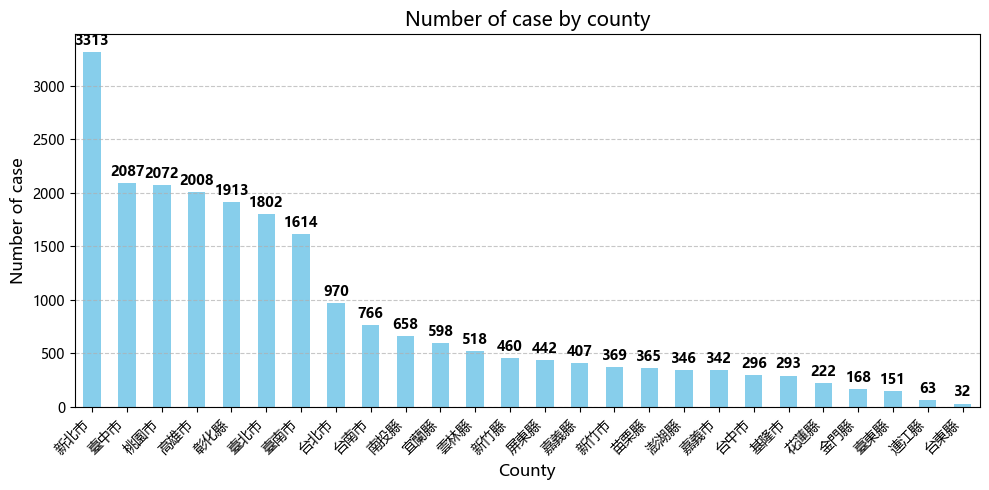

In [181]:
# 案件分布
county_counts = cleaned_df['Place_County'].value_counts()

plt.figure(figsize=(10, 5))
ax = county_counts.plot(kind='bar', color='skyblue')

# 設置中文字體 (如果有需要)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 在每個條形圖上添加數值標籤
for i, v in enumerate(county_counts):
    ax.text(i, v + (max(county_counts) * 0.02), f"{v}", ha='center', fontweight='bold')

plt.title('Number of case by county', fontsize=14)
plt.xlabel('County', fontsize=12)
plt.ylabel('Number of case', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

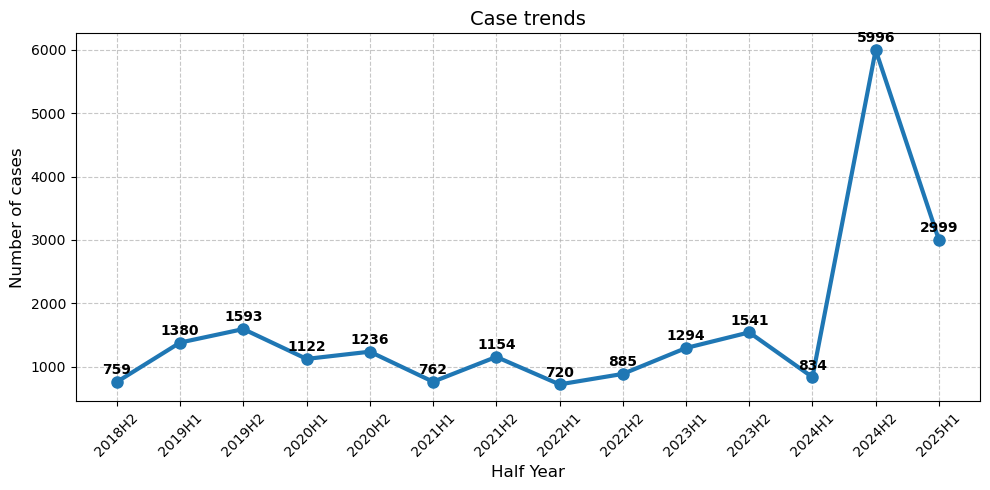

In [175]:
# 時間趨勢圖
cleaned_df['Half_Year'] = cleaned_df['Occurrence_Date'].apply(
    lambda x: f"{x.year}H1" if x.month < 7 else f"{x.year}H2"
)

half_year_counts = cleaned_df['Half_Year'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
ax = half_year_counts.plot(kind='line', marker='o', markersize=8, linewidth=3)

# 確保所有的半年度標籤都顯示
plt.xticks(range(len(half_year_counts)), half_year_counts.index, rotation=45)

# 在每個數據點上標記數值
for i, v in enumerate(half_year_counts):
    ax.text(i, v + (max(half_year_counts) * 0.02), f"{v}", ha='center', fontweight='bold')

plt.title('Case trends', fontsize=14)
plt.xlabel('Half Year', fontsize=12)
plt.ylabel('Number of cases', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()